<a href="https://colab.research.google.com/github/lmencisoe/CDA/blob/main/Taller3/Modelo_Taller3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --upgrade pandas-profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 315 kB 5.7 MB/s 
     |████████████████████████████████| 690 kB 15.1 MB/s 
     |████████████████████████████████| 102 kB 15.9 MB/s 
     |████████████████████████████████| 62 kB 1.2 MB/s 
     |████████████████████████████████| 9.9 MB 42.1 MB/s 
     |████████████████████████████████| 4.7 MB 40.6 MB/s 
     |████████████████████████████████| 296 kB 42.4 MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=e2050b8d989cb64bffe989ecc8642422dc555154ba1a1f60d0a11f14029bd635
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d201a26d0bd3ee8655
Successfully built htmlmin
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2
  Attempting uninstall: requests
   

In [3]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.7 MB/s 


In [4]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from pandas_profiling import ProfileReport
import tensorflow as tf
from sklearn.feature_extraction import DictVectorizer
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from xgboost import plot_importance
from keras.layers import Dropout, Flatten, Dense, Input, Rescaling, Lambda, MaxPooling2D, Conv2D, AveragePooling2D
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection  import GridSearchCV
from matplotlib import pyplot
import seaborn as sns
import shap
import warnings
import re
warnings.filterwarnings('ignore')

Mounted at /content/drive


In [5]:
df=pd.read_csv("/content/drive/MyDrive/Taller3_CDA/Data_Taller_3_modelo.csv",sep=";")

In [6]:
df2 = df.copy()
df2 = df2[df2['NewEmployee']==0]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1506 entries, 0 to 1505
Data columns (total 46 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   JobSatisfaction                       1494 non-null   float64
 1   Age                                   1506 non-null   float64
 2   Attrition                             1506 non-null   int64  
 3   DailyRate                             1506 non-null   float64
 4   DistanceFromHome                      1506 non-null   float64
 5   HourlyRate                            1506 non-null   float64
 6   MonthlyIncome                         1506 non-null   float64
 7   MonthlyRate                           1506 non-null   float64
 8   NumCompaniesWorked                    1506 non-null   float64
 9   OverTime                              1506 non-null   int64  
 10  PercentSalaryHike                     1506 non-null   float64
 11  TrainingTimesLast

In [8]:
X_total = df2.drop(['JobSatisfaction'], axis=1)
Y_total = df2['JobSatisfaction']

In [9]:
#multi:softprob

#*Entrena modelo base para selección de mejores variables (XgBoost)*

In [10]:
xgb_base = xgb.XGBClassifier(objective='multi:softprob',
         seed = 2022)

xgb_base.fit(X_total,
         Y_total,  
         eval_metric="merror")

XGBClassifier(objective='multi:softprob', seed=2022)

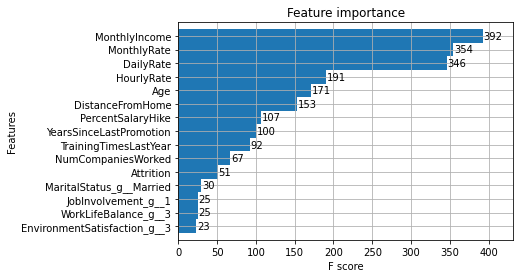

In [11]:
plot_importance(xgb_base, height = 1, max_num_features = 15)
pyplot.show()

# *Se decide dejar las variables: MonhtlyIncome, MonthlyRate, DailyRate, HourlyRate, Age, DistanceFromHome, PercentSalaryHike y YearsSinceLastPromotion*\\
*Con las demás se decide construir kmeans y grupos para reducir dimensionalidad*

In [12]:
df3 = df.copy()
df3.shape

(1506, 46)

In [13]:
X_total = df3.drop(['JobSatisfaction'], axis=1)

In [14]:
X_base = X_total[['MonthlyIncome','MonthlyRate', 'DailyRate', 'HourlyRate', 'Age', 'DistanceFromHome', 'PercentSalaryHike', 'YearsSinceLastPromotion','NewEmployee']]
X_resto = X_total.drop(['MonthlyIncome','MonthlyRate', 'DailyRate', 'HourlyRate', 'Age', 'DistanceFromHome', 'PercentSalaryHike', 'YearsSinceLastPromotion'], axis=1)

# **Se construye un PCA con las demás variables (Esto hace parte del bono)**

In [15]:
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(X_resto)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2','pc3', 'pc4','pc5', 'pc6','pc7', 'pc8','pc9', 'pc10'])

# Se usa un kmeans y método del codo para seleccionar 5 grupos, con el fin de resumir las variables restantes en estos 5 grupos y que sean features del nuevo modelo.

In [16]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(principalDf)
    sse.append(kmeans.inertia_)

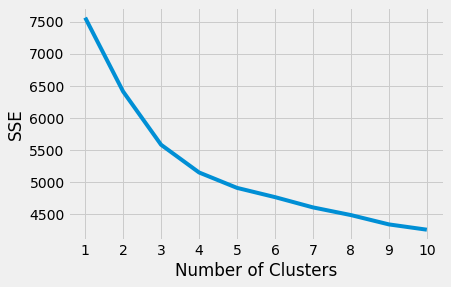

In [17]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [18]:
kmeans = KMeans(
     init="random",
     n_clusters=5,
     n_init=10,
     max_iter=300,
     random_state=42)
kmeans.fit(principalDf)
kmeans.labels_[:5]

array([0, 4, 0, 1, 0], dtype=int32)

In [19]:
X_base['new'] = kmeans.labels_

In [20]:
dummies_1 = pd.get_dummies(X_base['new'], prefix='cluster_g_').reset_index(drop=True)
X_base = pd.concat([X_base.reset_index(drop=True), dummies_1], axis=1)

In [21]:
X_base = X_base.drop(columns=['new'])

Nuevas X con las variables seleccionadas y los grupos del kmeans con la reducción de dimensionalidad:

In [22]:
X_base

,MonthlyIncome,MonthlyRate,DailyRate,HourlyRate,Age,DistanceFromHome,PercentSalaryHike,YearsSinceLastPromotion,NewEmployee,cluster_g__0,cluster_g__1,cluster_g__2,cluster_g__3,cluster_g__4
0,-0.099794,0.736982,0.737990,1.343204,0.446668,-1.011882,-1.147041,-0.679156,0,1,0,0,0,0
1,-0.283062,1.501137,-1.300005,-0.248844,1.318864,-0.151133,2.136553,-0.366179,0,0,0,0,0,1
2,-0.928641,-1.667968,1.409068,1.246716,0.010569,-0.888918,-0.052510,-0.679156,0,1,0,0,0,0
3,-0.754717,1.255053,1.456117,-0.490063,-0.425529,-0.765954,-1.147041,0.259775,0,0,1,0,0,0
4,-0.636007,0.336180,-0.527399,-1.261965,-1.406750,-0.888918,-0.873408,-0.053202,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1501,0.040365,0.145282,0.101581,-1.020745,-0.098455,-1.011882,-0.052510,-0.679156,0,0,0,1,0,0
1502,1.413707,-0.332949,-1.560017,-0.490063,1.318864,-0.151133,0.494756,-0.053202,0,1,0,0,0,0
1503,-0.509014,0.288033,1.233250,0.040620,-1.079676,1.201472,-1.147041,-0.679156,0,0,0,0,0,1
1504,-0.875126,-0.443743,-0.928560,1.584423,0.773742,-1.011882,-0.873408,-0.053202,0,0,0,0,0,1


In [23]:
X_base_model = X_base[X_base['NewEmployee'] == 0]
X_base_model = X_base_model.drop(columns=['NewEmployee'])
Y_model = df2[df2['NewEmployee']==0]['JobSatisfaction']
Y_model

0       4.0
1       2.0
2       3.0
3       3.0
4       2.0
       ... 
1501    4.0
1502    2.0
1503    1.0
1504    2.0
1505    1.0
Name: JobSatisfaction, Length: 1494, dtype: float64

In [24]:
X_base_model

,MonthlyIncome,MonthlyRate,DailyRate,HourlyRate,Age,DistanceFromHome,PercentSalaryHike,YearsSinceLastPromotion,cluster_g__0,cluster_g__1,cluster_g__2,cluster_g__3,cluster_g__4
0,-0.099794,0.736982,0.737990,1.343204,0.446668,-1.011882,-1.147041,-0.679156,1,0,0,0,0
1,-0.283062,1.501137,-1.300005,-0.248844,1.318864,-0.151133,2.136553,-0.366179,0,0,0,0,1
2,-0.928641,-1.667968,1.409068,1.246716,0.010569,-0.888918,-0.052510,-0.679156,1,0,0,0,0
3,-0.754717,1.255053,1.456117,-0.490063,-0.425529,-0.765954,-1.147041,0.259775,0,1,0,0,0
4,-0.636007,0.336180,-0.527399,-1.261965,-1.406750,-0.888918,-0.873408,-0.053202,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1501,0.040365,0.145282,0.101581,-1.020745,-0.098455,-1.011882,-0.052510,-0.679156,0,0,1,0,0
1502,1.413707,-0.332949,-1.560017,-0.490063,1.318864,-0.151133,0.494756,-0.053202,1,0,0,0,0
1503,-0.509014,0.288033,1.233250,0.040620,-1.079676,1.201472,-1.147041,-0.679156,0,0,0,0,1
1504,-0.875126,-0.443743,-0.928560,1.584423,0.773742,-1.011882,-0.873408,-0.053202,0,0,0,0,1


In [25]:
Y_model = Y_model.apply(int)
Y_model

0       4
1       2
2       3
3       3
4       2
       ..
1501    4
1502    2
1503    1
1504    2
1505    1
Name: JobSatisfaction, Length: 1494, dtype: int64

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_base_model, Y_model, test_size=0.33, random_state=2022)

# **Tunning de hiperparámetros del XGBoost (Esto hace parte del bono)**

In [27]:
xgb_model = xgb.XGBClassifier()

parameters = {'nthread':[3], #when use hyperthread, xgboost may become slower
              'objective':['multi:softprob'],
              'learning_rate': [0.01,0.05,0.1], #so called `eta` value
              'max_depth': [2,4,6],
              'subsample': [0.1,0.15],
              'colsample_bytree': [0.1,0.15],
              'n_estimators': [40,80], #number of trees, change it to 1000 for better results
              'seed': [2022]}


xgb_grid = GridSearchCV(xgb_model,
                        parameters,
                        cv = 3,
                        n_jobs = 3,
                        verbose=True)

In [28]:
with tf.device('/device:GPU:0'): 
    xgb_grid.fit(X_train, 
                 y_train,
                 eval_metric="merror",
                 early_stopping_rounds=20,
                 eval_set = [(X_train, y_train),(X_test, y_test)])    

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[0]	validation_0-merror:0.67	validation_1-merror:0.712551
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.671	validation_1-merror:0.680162
[2]	validation_0-merror:0.641	validation_1-merror:0.706478
[3]	validation_0-merror:0.639	validation_1-merror:0.698381
[4]	validation_0-merror:0.63	validation_1-merror:0.700405
[5]	validation_0-merror:0.639	validation_1-merror:0.694332
[6]	validation_0-merror:0.653	validation_1-merror:0.665992
[7]	validation_0-merror:0.651	validation_1-merror:0.678138
[8]	validation_0-merror:0.663	validation_1-merror:0.688259
[9]	validation_0-merror:0.664	validation_1-merror:0.686235
[10]	validation_0-merror:0.663	validation_1-merror:0.690283
[11]	validation_0-merror:0.658	validation_1-merror:0.694332
[12]	validation_0-merror:0.648	validation_1-merror:0.694332
[13]	va

In [29]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.3289846732960506
{'colsample_bytree': 0.1, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 40, 'nthread': 3, 'objective': 'multi:softprob', 'seed': 2022, 'subsample': 0.1}


Mejor modelo del XGBoost:

In [30]:
xgb_selecc = xgb.XGBClassifier(nthread=3, #when use hyperthread, xgboost may become slower
         objective='multi:softprob',
         learning_rate= 0.05, #so called `eta` value
         max_depth= 4,
         n_estimators = 40,
         subsample= 0.1,
         colsample_bytree= 0.1,
         seed = 2022)

xgb_selecc.fit(X_train,
         y_train,  
         eval_metric="merror",
         early_stopping_rounds=20,
         eval_set = [(X_train, y_train),(X_test, y_test)])

[0]	validation_0-merror:0.67	validation_1-merror:0.712551
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.671	validation_1-merror:0.680162
[2]	validation_0-merror:0.641	validation_1-merror:0.706478
[3]	validation_0-merror:0.639	validation_1-merror:0.698381
[4]	validation_0-merror:0.63	validation_1-merror:0.700405
[5]	validation_0-merror:0.639	validation_1-merror:0.694332
[6]	validation_0-merror:0.653	validation_1-merror:0.665992
[7]	validation_0-merror:0.651	validation_1-merror:0.678138
[8]	validation_0-merror:0.663	validation_1-merror:0.688259
[9]	validation_0-merror:0.664	validation_1-merror:0.686235
[10]	validation_0-merror:0.663	validation_1-merror:0.690283
[11]	validation_0-merror:0.658	validation_1-merror:0.694332
[12]	validation_0-merror:0.648	validation_1-merror:0.694332
[13]	validation_0-merror:0.648	validation_1-merror:0.698381
[14]	vali

XGBClassifier(colsample_bytree=0.1, learning_rate=0.05, max_depth=4,
              n_estimators=40, nthread=3, objective='multi:softprob', seed=2022,
              subsample=0.1)

In [31]:
pred_modelo_train = xgb_selecc.predict(X_train)
pred_modelo_test = xgb_selecc.predict(X_test)

In [32]:
class_names = ['1','2','3','4']

In [33]:
print(classification_report(y_train,pred_modelo_train,target_names=list(class_names)))

              precision    recall  f1-score   support

           1       0.14      0.01      0.01       190
           2       0.35      0.06      0.11       191
           3       0.35      0.58      0.43       314
           4       0.35      0.50      0.41       305

    accuracy                           0.35      1000
   macro avg       0.30      0.29      0.24      1000
weighted avg       0.31      0.35      0.28      1000



In [34]:
print(classification_report(y_test,pred_modelo_test,target_names=list(class_names)))

              precision    recall  f1-score   support

           1       0.33      0.02      0.04        98
           2       0.22      0.05      0.08        88
           3       0.32      0.56      0.40       140
           4       0.36      0.48      0.41       168

    accuracy                           0.33       494
   macro avg       0.31      0.28      0.23       494
weighted avg       0.32      0.33      0.28       494



In [35]:
accuracy_score(y_train, pred_modelo_train), accuracy_score(y_test, pred_modelo_test)

(0.347, 0.3340080971659919)

# **Importancia de variables (este es el modelo seleccionado, más adelante se justifica)**

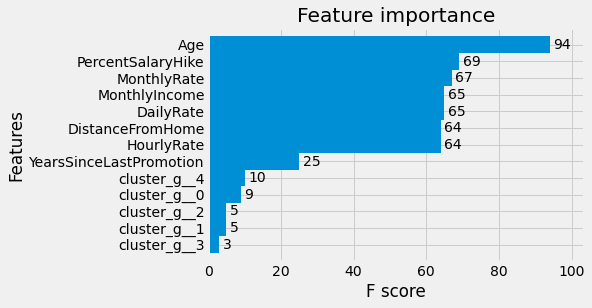

In [36]:
plot_importance(xgb_selecc, height = 1, max_num_features = 15)
pyplot.show()

#*Random Forest*

In [37]:
parameters = {
    'n_estimators': [10,20,30],
    'max_depth': [2,5,7],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [3,5,7]
}
regr = RandomForestClassifier(random_state=0)

clf = GridSearchCV(regr, 
                   parameters,
                   cv = 5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [2, 5, 7],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [3, 5, 7],
                         'n_estimators': [10, 20, 30]})

In [38]:
print(clf.best_score_)
print(clf.best_params_)

0.329
{'max_depth': 7, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 30}


Mejor RandomForest

In [39]:
rf_selecc = RandomForestClassifier(
         n_estimators= 30, #so called `eta` value
         max_features = 'auto',
         max_depth=7,
         min_samples_split = 3)

rf_selecc.fit(X_train,
         y_train)

RandomForestClassifier(max_depth=7, min_samples_split=3, n_estimators=30)

In [40]:
pred_modelo_train = rf_selecc.predict(X_train)
pred_modelo_test = rf_selecc.predict(X_test)

In [41]:
print(classification_report(y_train,pred_modelo_train,target_names=list(class_names)))

              precision    recall  f1-score   support

           1       0.99      0.41      0.58       190
           2       1.00      0.45      0.62       191
           3       0.66      0.88      0.75       314
           4       0.66      0.90      0.76       305

    accuracy                           0.71      1000
   macro avg       0.83      0.66      0.68      1000
weighted avg       0.79      0.71      0.70      1000



In [42]:
print(classification_report(y_test,pred_modelo_test,target_names=list(class_names)))

              precision    recall  f1-score   support

           1       0.17      0.02      0.04        98
           2       0.11      0.02      0.04        88
           3       0.28      0.46      0.35       140
           4       0.34      0.48      0.40       168

    accuracy                           0.30       494
   macro avg       0.23      0.25      0.21       494
weighted avg       0.25      0.30      0.25       494



In [43]:
accuracy_score(y_train, pred_modelo_train), accuracy_score(y_test, pred_modelo_test)

(0.714, 0.3016194331983806)

#*Arbol de decisión*

In [44]:
parameters = {
    'max_depth': [2,5,7],
    'min_samples_split': [3,5,7],
    'max_features': ['auto', 'sqrt', 'log2']
}
regr_arb = DecisionTreeClassifier(random_state=0)

arbol = GridSearchCV(regr_arb, 
                   parameters,
                   cv = 5)
arbol.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [2, 5, 7],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [3, 5, 7]})

In [45]:
print(arbol.best_score_)
print(arbol.best_params_)

0.324
{'max_depth': 2, 'max_features': 'auto', 'min_samples_split': 3}


Mejor árbol de decisión:

In [46]:
arbol_selecc = DecisionTreeClassifier(
         max_depth= 2, #so called `eta` value
         min_samples_split = 3,
         max_features = 'auto')

arbol_selecc.fit(X_train,
         y_train)

DecisionTreeClassifier(max_depth=2, max_features='auto', min_samples_split=3)

In [47]:
pred_modelo_train = arbol_selecc.predict(X_train)
pred_modelo_test = arbol_selecc.predict(X_test)

In [48]:
print(classification_report(y_train,pred_modelo_train,target_names=list(class_names)))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       190
           2       0.50      0.01      0.01       191
           3       0.32      0.99      0.48       314
           4       0.80      0.03      0.05       305

    accuracy                           0.32      1000
   macro avg       0.40      0.26      0.14      1000
weighted avg       0.44      0.32      0.17      1000



In [49]:
print(classification_report(y_test,pred_modelo_test,target_names=list(class_names)))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        98
           2       0.00      0.00      0.00        88
           3       0.28      0.99      0.44       140
           4       0.00      0.00      0.00       168

    accuracy                           0.28       494
   macro avg       0.07      0.25      0.11       494
weighted avg       0.08      0.28      0.12       494



In [50]:
accuracy_score(y_train, pred_modelo_train), accuracy_score(y_test, pred_modelo_test)

(0.321, 0.2813765182186235)

#*Red Neuronal*

In [51]:
y_dict = [{'':str(x)} for x in y_train.tolist()]
y_dict_test = [{'':str(x)} for x in y_test.tolist()]


In [52]:
vec = DictVectorizer(sparse=False, dtype=int)
M_train = vec.fit_transform(y_dict)
M_test = vec.fit_transform(y_dict_test)

In [53]:
model = Sequential(name="RedNeuronal")
model.add(Input(shape=(13),name='Capa_Entrada'))
model.add(Dense(16,activation='relu',name='Capa_Densa_3'))
model.add(Dense(8,activation='relu',name='Capa_Densa_4'))
model.add(Dense(len(class_names),activation='softmax',name='Capa_Respuesta'))
model.compile(loss='categorical_crossentropy', optimizer='sgd',metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

Model: "RedNeuronal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Densa_3 (Dense)        (None, 16)                224       
                                                                 
 Capa_Densa_4 (Dense)        (None, 8)                 136       
                                                                 
 Capa_Respuesta (Dense)      (None, 4)                 36        
                                                                 
Total params: 396
Trainable params: 396
Non-trainable params: 0
_________________________________________________________________


In [54]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=4)
]

In [55]:
history = model.fit(X_train, 
        M_train,           
        validation_data=([X_test, M_test]),
        epochs=50,
        callbacks=my_callbacks
    )

Epoch 1/50
32/32 [==============================] - 2s 20ms/step - loss: 1.4330 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4096 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
32/32 [==============================] - 0s 3ms/step - loss: 1.4114 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
32/32 [==============================] - 0s 5ms/step - loss: 1.3984 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3920 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
32/32 [==============================] - 0s 4ms/step - loss: 1.3906 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3878 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
32/32 [==============================] - 0s 4ms/step - loss: 1.3848 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3854 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/50
32/32 [=

In [56]:
pred_train = model.predict(X_train)
y_pred = list()
for i in range(len(pred_train)):
    y_pred.append((pred_train[i] == pred_train[i].max()).astype(int))

32/32 [==============================] - 0s 1ms/step


In [57]:
y_pred = np.array(y_pred)
print(classification_report(M_train,y_pred,target_names=list(class_names)))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       190
           2       0.00      0.00      0.00       191
           3       0.36      0.65      0.47       314
           4       0.33      0.47      0.39       305

   micro avg       0.35      0.35      0.35      1000
   macro avg       0.17      0.28      0.21      1000
weighted avg       0.21      0.35      0.26      1000
 samples avg       0.35      0.35      0.35      1000



In [58]:
accuracy_score(M_train, y_pred)

0.347

In [59]:
pred_test = model.predict(X_test)
y_pred_test = list()
for i in range(len(pred_test)):
    y_pred_test.append((pred_test[i] == pred_test[i].max()).astype(int))

16/16 [==============================] - 0s 1ms/step


In [60]:
y_pred_test = np.array(y_pred_test)
print(classification_report(M_test,y_pred_test,target_names=list(class_names)))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        98
           2       0.00      0.00      0.00        88
           3       0.30      0.60      0.40       140
           4       0.33      0.41      0.37       168

   micro avg       0.31      0.31      0.31       494
   macro avg       0.16      0.25      0.19       494
weighted avg       0.20      0.31      0.24       494
 samples avg       0.31      0.31      0.31       494



In [61]:
accuracy_score(M_test, y_pred_test)

0.3097165991902834

# *Se selecciona el XGBoost con los hiperparámetros mostrados anteriormente, ya que no presenta sobreajuste y además, predice de una forma estable las 4 categorías* (Esto se aprecia en el classification_report())

# **Interpretación**
*Se puede apreciar en la matriz de importancia que en el top aparecen tanto la edad como el MonthlyIncome, por lo tanto, son features significativas para el modelo*

In [62]:
explainer = shap.Explainer(xgb_grid.best_estimator_.predict, X_train)
shap_values = explainer(X_train)

Permutation explainer: 1001it [01:26, 10.67it/s]


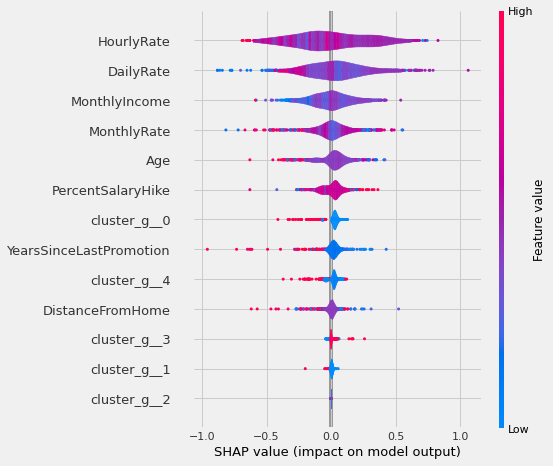

In [63]:
shap.summary_plot(shap_values, plot_type = 'violin')

Con el shap se puede apreciar claramente que: \\
1. Valores altos de MonthlyRate afectan negativamente el output, mientras que valores bajos lo afectan positivamente. \\
2. Se apreciar también que con la reducción de dimensionalidad, trabajadores en el cluster 0 tienden a estar menos satisfechos que trabajadores que no pertenecen a este cluster. \\
3. Además, es interesante también, ver como a mayor cantidad de años desde la última promoción (YearsSinceLastPromotion) la satisfacción es más baja.

# **Evaluación**

Los siguientes son los acc de los diferentes modelos:
1. XGBoost -> train: 34.7% , test: 33.4%
2. RandomForest -> train: 68.8%, test_28.7%
3. DecisionTree -> train: 32.6%, test: 34.1%
4. Red Neuronal -> train: 33.4%, test: 29.4%

Y se selecciona el XGBoost como se comenta antes, ya que es el único que predice sobre las 4 variables, además de no presentar sobreajuste.

Estrategias:
1. Tomar algún tipo de iniciativa con los trabajadores de mayor edad, ya que esta variable, al incrementar afecta negativamente la satisfacción.
2. Mayor promoción interna, antes de contratación de nuevos empleados.
3. Permitir, de ser posible el trabajo remoto, ya que se aprecia que a mayor distancia del hogar, esto afecta negativamente.

# **Estimación de nuevos empleados**

In [64]:
X_new_model = X_base[X_base['NewEmployee'] == 1]

In [65]:
X_new_model = X_new_model.drop(columns=['NewEmployee'])

In [66]:
pred_modelo_new = xgb_selecc.predict(X_new_model)

In [67]:
pred_modelo_new

array([4, 3, 4, 4, 3, 3, 4, 3, 3, 4, 3, 4])

# **Bono: Ya se realizó anteriormente**